This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce     

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
model_x = set_x     

merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print(test_sh_L[0])
print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[1667, 144, 62, 85], [1667, 144, 62, 85]]]
model is LR
[0, [[1027, 379, 62, 85], [4547, 3142, 379, 62, 85], [1027, 379, 62, 85]]]
[1, [[673, 124, 449, 267, 84, 63], [1677, 124, 449, 267, 84, 63], [793, 124, 449, 267, 84, 63], [9565, 124, 449, 3565, 267, 84, 63], [148, 673, 124, 449, 267, 84, 63], [2399, 148, 124, 449, 3565, 267, 84, 63], [115, 246, 124, 414, 129, 5148, 1442, 420, 6757, 156, 15, 185, 186, 93, 259, 960, 221, 1259, 2413, 6, 26, 111, 29, 213, 80, 214, 570, 31, 370, 8, 192, 35, 10, 40, 553, 43, 44, 49, 959, 82, 880, 267, 84, 63], [358, 559, 124, 449, 267, 84, 63], [717, 396, 370, 8, 267, 84, 63], [433, 146, 513, 321, 246, 449, 129, 1442, 156, 16, 89, 954, 3067, 960, 1259, 135, 26, 262, 855, 956, 80, 214, 190, 32, 139, 37, 880, 267, 84, 63], [673, 124, 129, 277, 267, 84, 63], [150, 113, 7525, 4535, 267, 84, 63], [556, 9566, 132, 267, 84, 63], [124, 129, 132, 267, 84, 63], [346, 5594, 267, 84, 63], [268, 793, 449, 

In [14]:
print(len(merged_set))

42729


In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
 1.6521e+00
-3.2884e-01
-1.0285e+00
     ⋮      
 6.5434e-01
 5.2814e-01
 2.3138e-01
[torch.FloatTensor of size 20000x1]

        emb                           types
0  1.652050                            Code
1 -0.328840  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -1.028486         b'M_BACITRACIN TOPICAL'
3 -0.518897    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.053976                  b'M_CEFAZOLIN'


In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.5489008177025997


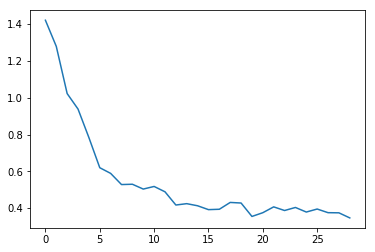

Epoch  0 Summary:  Training_auc : 0.5783411100257255  , Validation_auc :  0.55558096418367  ,Test_auc :  0.5738992167089048 Test_auc on short visits: 0.5693546351715539 Test_auc on long visits: 0.543846779422593  Avg Loss:  0.5489008177025997 Train Time (0m 42s) Eval Time (0m 23s)

 Current running on: Epoch  1 Training loss:  Average loss 0.36647863118314244


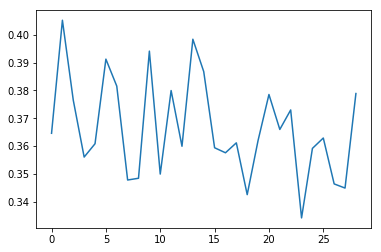

Epoch  1 Summary:  Training_auc : 0.6313751937433303  , Validation_auc :  0.606876612969766  ,Test_auc :  0.6226920814527014 Test_auc on short visits: 0.6252498270618619 Test_auc on long visits: 0.6087132618260013  Avg Loss:  0.36647863118314244 Train Time (0m 44s) Eval Time (0m 22s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3571496356472502


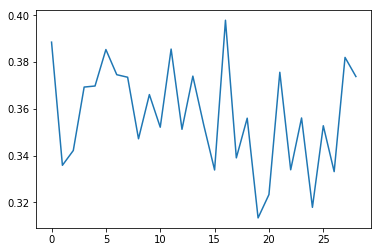

Epoch  2 Summary:  Training_auc : 0.6780134322022542  , Validation_auc :  0.6587230552427289  ,Test_auc :  0.6724936683765834 Test_auc on short visits: 0.6666984903673292 Test_auc on long visits: 0.6705094531081145  Avg Loss:  0.3571496356472502 Train Time (0m 45s) Eval Time (0m 34s)

 Current running on: Epoch  3 Training loss:  Average loss 0.3485549220110025


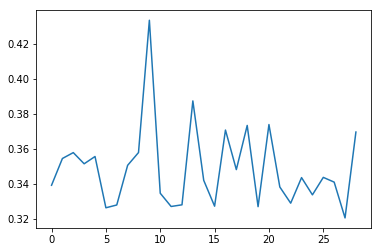

Epoch  3 Summary:  Training_auc : 0.7196904788650547  , Validation_auc :  0.7051066424710956  ,Test_auc :  0.7197424138136401 Test_auc on short visits: 0.7363471368910249 Test_auc on long visits: 0.7129884533242484  Avg Loss:  0.3485549220110025 Train Time (1m 6s) Eval Time (0m 23s)

 Current running on: Epoch  4 Training loss:  Average loss 0.3408936020271733


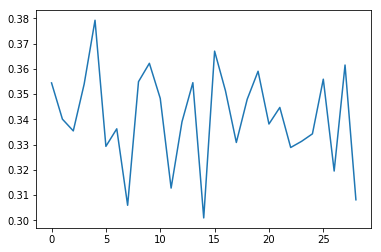

Epoch  4 Summary:  Training_auc : 0.7464941932057401  , Validation_auc :  0.7327293729751645  ,Test_auc :  0.7531479311439182 Test_auc on short visits: 0.7830668621456749 Test_auc on long visits: 0.7441465277548822  Avg Loss:  0.3408936020271733 Train Time (0m 43s) Eval Time (0m 23s)

 Current running on: Epoch  5 Training loss:  Average loss 0.33468411276772375


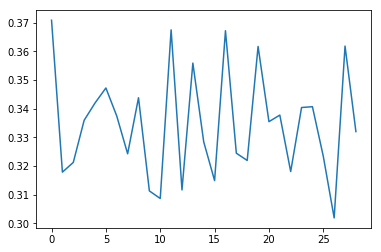

Epoch  5 Summary:  Training_auc : 0.7662041520354423  , Validation_auc :  0.7530546362003555  ,Test_auc :  0.775184944863954 Test_auc on short visits: 0.8027920507258777 Test_auc on long visits: 0.7717438887240411  Avg Loss:  0.33468411276772375 Train Time (0m 43s) Eval Time (0m 23s)

 Current running on: Epoch  6 Training loss:  Average loss 0.3299466994009427


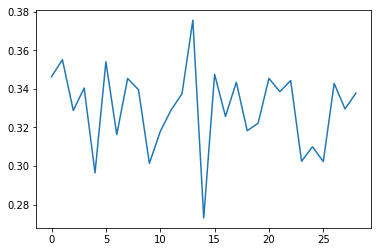

Epoch  6 Summary:  Training_auc : 0.7771660254649455  , Validation_auc :  0.7640967341989752  ,Test_auc :  0.7915946798318384 Test_auc on short visits: 0.8120610063645198 Test_auc on long visits: 0.791230277786936  Avg Loss:  0.3299466994009427 Train Time (0m 39s) Eval Time (0m 22s)

 Current running on: Epoch  7 Training loss:  Average loss 0.327176780668005


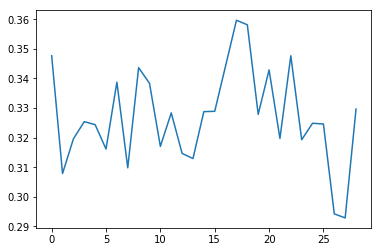

Epoch  7 Summary:  Training_auc : 0.786712739267358  , Validation_auc :  0.7693172510377922  ,Test_auc :  0.8016195576117223 Test_auc on short visits: 0.8168200260712088 Test_auc on long visits: 0.8001091659065349  Avg Loss:  0.327176780668005 Train Time (0m 37s) Eval Time (0m 22s)

 Current running on: Epoch  8 Training loss:  Average loss 0.32399603187350356


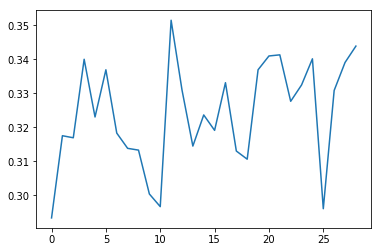

Epoch  8 Summary:  Training_auc : 0.7946768086395484  , Validation_auc :  0.7734842660485539  ,Test_auc :  0.8077667324689564 Test_auc on short visits: 0.8143291883238511 Test_auc on long visits: 0.810436883423267  Avg Loss:  0.32399603187350356 Train Time (0m 37s) Eval Time (0m 22s)

 Current running on: Epoch  9 Training loss:  Average loss 0.32275820857826865


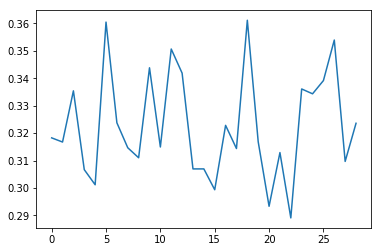

Epoch  9 Summary:  Training_auc : 0.7969855104145522  , Validation_auc :  0.7774529298333904  ,Test_auc :  0.8083453013004269 Test_auc on short visits: 0.8159611165031544 Test_auc on long visits: 0.810949743386854  Avg Loss:  0.32275820857826865 Train Time (0m 43s) Eval Time (0m 26s)

 Current running on: Epoch  10 Training loss:  Average loss 0.320661683890329


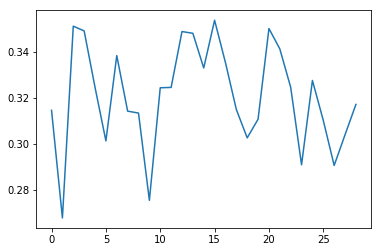

Epoch  10 Summary:  Training_auc : 0.7943155484965654  , Validation_auc :  0.7680558355968871  ,Test_auc :  0.8023287293486281 Test_auc on short visits: 0.8178936630312768 Test_auc on long visits: 0.8000340685547239  Avg Loss:  0.320661683890329 Train Time (0m 47s) Eval Time (0m 24s)

 Current running on: Epoch  11 Training loss:  Average loss 0.3221352407119259


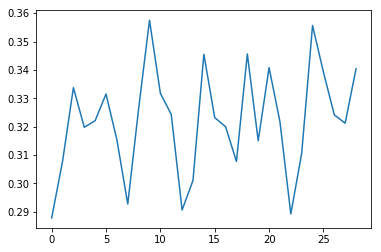

Epoch  11 Summary:  Training_auc : 0.7981972491477343  , Validation_auc :  0.7717510151156748  ,Test_auc :  0.8057840294334486 Test_auc on short visits: 0.8166489048572658 Test_auc on long visits: 0.805743298935083  Avg Loss:  0.3221352407119259 Train Time (0m 36s) Eval Time (0m 19s)

 Current running on: Epoch  12 Training loss:  Average loss 0.3204512505596273


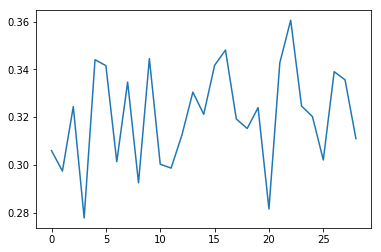

Epoch  12 Summary:  Training_auc : 0.8002202333933862  , Validation_auc :  0.7759764972922052  ,Test_auc :  0.8105617434243715 Test_auc on short visits: 0.8176855426359407 Test_auc on long visits: 0.8122298326977533  Avg Loss:  0.3204512505596273 Train Time (0m 49s) Eval Time (0m 40s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3198721118510436


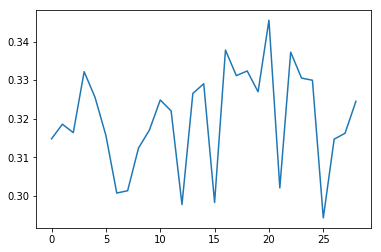

Epoch  13 Summary:  Training_auc : 0.7993512906092763  , Validation_auc :  0.7704581804034453  ,Test_auc :  0.8087965985863612 Test_auc on short visits: 0.8122162707864375 Test_auc on long visits: 0.810759252543236  Avg Loss:  0.3198721118510436 Train Time (0m 34s) Eval Time (0m 19s)

 Current running on: Epoch  14 Training loss:  Average loss 0.3187948449767248


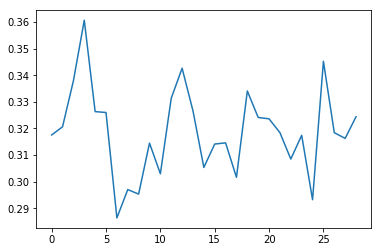

Epoch  14 Summary:  Training_auc : 0.7942156572608571  , Validation_auc :  0.7646565436506569  ,Test_auc :  0.8044248345945817 Test_auc on short visits: 0.8110468323745481 Test_auc on long visits: 0.80667949732397  Avg Loss:  0.3187948449767248 Train Time (0m 39s) Eval Time (0m 19s)

 Current running on: Epoch  15 Training loss:  Average loss 0.3179975266161612


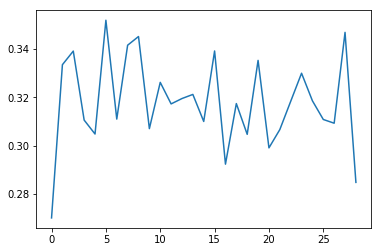

Epoch  15 Summary:  Training_auc : 0.8011790003996503  , Validation_auc :  0.771402397809503  ,Test_auc :  0.8086104503536273 Test_auc on short visits: 0.8138462168667375 Test_auc on long visits: 0.8099400503335421  Avg Loss:  0.3179975266161612 Train Time (0m 36s) Eval Time (0m 19s)

 Current running on: Epoch  16 Training loss:  Average loss 0.31850163269756054


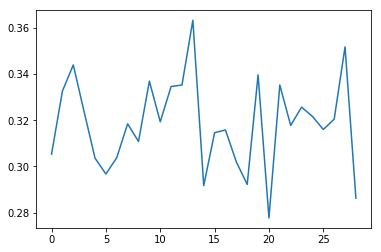

Epoch  16 Summary:  Training_auc : 0.7990990871123277  , Validation_auc :  0.761684007372327  ,Test_auc :  0.8048179350626853 Test_auc on short visits: 0.8159277511699339 Test_auc on long visits: 0.8035608966257477  Avg Loss:  0.31850163269756054 Train Time (0m 38s) Eval Time (0m 19s)

 Current running on: Epoch  17 Training loss:  Average loss 0.31868053729461043


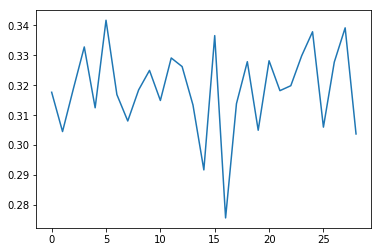

Epoch  17 Summary:  Training_auc : 0.800434238789092  , Validation_auc :  0.7713868247793683  ,Test_auc :  0.8069293373694004 Test_auc on short visits: 0.8131990615421918 Test_auc on long visits: 0.8075634938951348  Avg Loss:  0.31868053729461043 Train Time (0m 39s) Eval Time (0m 19s)

 Current running on: Epoch  18 Training loss:  Average loss 0.3187689267151715


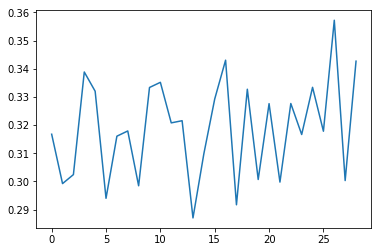

Epoch  18 Summary:  Training_auc : 0.7989653190689531  , Validation_auc :  0.7667042605078338  ,Test_auc :  0.8050433117579054 Test_auc on short visits: 0.8143483486142155 Test_auc on long visits: 0.8054081083160243  Avg Loss:  0.3187689267151715 Train Time (0m 39s) Eval Time (0m 19s)

 Current running on: Epoch  19 Training loss:  Average loss 0.31926987532137535


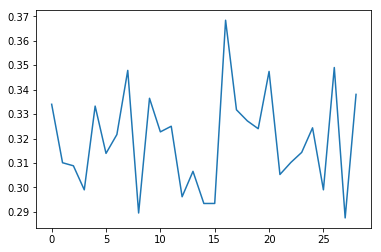

Epoch  19 Summary:  Training_auc : 0.8015816062527775  , Validation_auc :  0.7723127370447417  ,Test_auc :  0.8104046936005528 Test_auc on short visits: 0.8154487439108267 Test_auc on long visits: 0.8124603907260266  Avg Loss:  0.31926987532137535 Train Time (0m 39s) Eval Time (0m 19s)


In [9]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [10]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

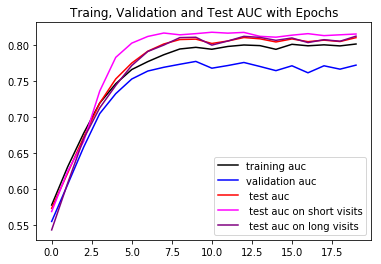

In [11]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [12]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_original_longshort_dim1')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

In [13]:
#extract weights
torch.save(ehr_model, 'Lr1model_original_longshort')
z= pd.DataFrame(ehr_model.embedding.weight.cpu().data.numpy())
z.to_csv('embedding weights_dim1_original_longshort')
ehr_model.embedding.weight

Parameter containing:
-1.5532e-41
-3.9363e-02
-5.6611e-03
     ⋮      
-2.5344e-09
-3.3820e-15
-5.1611e-17
[torch.cuda.FloatTensor of size 20000x1 (GPU 0)]